# Random walk experiment

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

from scipy.special import expit as sigmoid

from tdsurv import CoxPH, unroll, concordance_index

In [2]:
def make_generator(mat, sigma, sigma0, thetas, bias, rng):
    """Sample from a Gauss-Markov process.
    
    Initial state:
    
        x_0 = noise(sigma0)
    
    Transition dynamics:
    
        x_nxt = np.dot(mat, x) + noise(sigma)
        
    Churn probability:
    
        p = sigmoid(np.dot(x, thetas) + bias)
    """
    n_dims = mat.shape[0]
    def gen(n_samples, horizon):
        seqs = np.zeros((n_samples, horizon + 1, n_dims + 1))
        ts = np.zeros(n_samples, dtype=int)
        cs = np.zeros(n_samples, dtype=bool)
        for i in range(n_samples):
            seqs[i, 0] = np.append(sigma0 * rng.normal(size=n_dims), 1)
            ts[i] = 1
            for j in range(0, horizon):
                p = sigmoid(np.dot(seqs[i, j, :-1], thetas) + bias)
                if rng.uniform() < p:
                    break
                ts[i] += 1
                seqs[i, j + 1] = np.append(
                    np.dot(mat, seqs[i, j + 1, :-1]) + sigma * rng.normal(size=n_dims),
                    1,
                )
            if ts[i] > horizon:
                ts[i] = horizon
                cs[i] = True
        return (seqs, ts, cs)
    return gen

## Problem instance

In [3]:
rng = np.random.default_rng(seed=0)
n_dims = 20
horizon = 10
d = n_dims + 1

# Churn parameters.
thetas = rng.normal(size=n_dims)
bias = -3

# Transition dynamics.
mat = 1.0 * np.eye(n_dims)
sigma = 0.5
sigma0 = 1.0 # Affect results quite a lot

gen = make_generator(mat, sigma, sigma0, thetas, bias, rng)
seqs_v, ts_v, cs_v = gen(n_samples=10000, horizon=horizon)

In [4]:
# Ground-truth parameters
model = CoxPH(horizon=horizon, n_feats=d)
model.fit(seqs_v, ts_v, cs_v, lambda_=1.0)
params_gt = model.params[:n_dims]

In [5]:
# N-fold cross-validation
n_folds = 5
data = list()
for i in range(n_folds):
    data.append(gen(n_samples=300, horizon=horizon))

sizes = np.linspace(20, 200, num=10, dtype=int)

def experiment(fn, vals):
    model = CoxPH(horizon=horizon, n_feats=d)
    res = np.zeros((n_folds, len(sizes), len(vals), 4))
    for fold in range(n_folds):
        seqs_t, ts_t, cs_t = data[fold]
        for i, size in enumerate(sizes):
            print(".", end="")
            for j, val in enumerate(vals):
                fn(model, val, seqs_t[:size], ts_t[:size], cs_t[:size])
                res[fold, i, j, 0] = model.loglike(seqs_v[:, 0], ts_v, cs_v)
                res[fold, i, j, 1] = model.integrated_brier_score(seqs_v[:, 0], ts_v, cs_v)
                res[fold, i, j, 2] = concordance_index(model.score(seqs_v[:, 0]), ts_v, cs_v)
                res[fold, i, j, 3] = np.linalg.norm(model.params[:n_dims] - params_gt)
        print()
    return res

def plot_res(res, vals):
    mean = res.mean(axis=0)
    #std = res.std(axis=0)
    fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(16, 10))
    for j, val in enumerate(vals):
        for k, ax in enumerate(axs.ravel()):
            ax.plot(sizes, mean[:, j, k], marker="o", label=f"val = {val:.3f}")
    for ax in axs.ravel():
        ax.legend()
        ax.grid()
    axs[1,0].set_xlabel("Number of patients")
    axs[1,1].set_xlabel("Number of patients")
    axs[0,0].set_title("Predictive log-likelihood")
    axs[0,1].set_title("Integrated Brier score")
    axs[1,0].set_title("Concordance index")
    axs[1,1].set_title("RMSE to ground-truth params")
    return (fig, axs)

Fraction of censored observations

In [6]:
print("Frac. censored:", sum(cs_v) / len(cs_v))
print("Median length:", np.median(ts_v + cs_v))
print("Max length:", np.max(ts_v + cs_v))

Frac. censored: 0.2186
Median length: 4.0
Max length: 11


## Experiments

Generate an independent test set using the same generative model, and measure the predictive log-likelihood of different survival models.

In [7]:
%%time
def initial_state(model, l2, seqs, ts, cs):
    model.params = np.zeros_like(model.params)
    model.fit(seqs, ts, cs, lambda_=1.0, l2=l2)

l2s = np.array([3.0, 10.0, 30.0, 100.0])
res_is = experiment(initial_state, l2s)

..........
..........
..........
..........
..........
CPU times: user 37.7 s, sys: 172 ms, total: 37.9 s
Wall time: 36.5 s


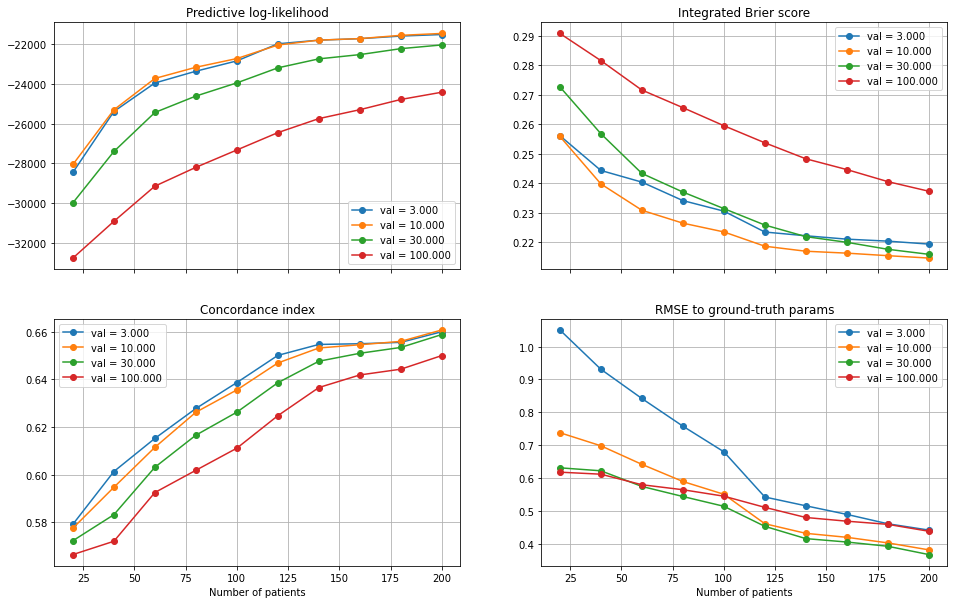

In [8]:
fig, axs = plot_res(res_is, l2s);

In [9]:
%%time
def landmarking(model, l2, seqs, ts, cs):
    model.params = np.zeros_like(model.params)
    seqs_, ts_, cs_ = unroll(seqs, ts, cs)
    model.fit(seqs_, ts_, cs_, lambda_=1.0, l2=l2)

l2s = np.array([1.0, 3.0, 10.0, 30.0, 100.0])
res_lm = experiment(landmarking, l2s)

..........
..........
..........
..........
..........
CPU times: user 1min 1s, sys: 892 ms, total: 1min 2s
Wall time: 57 s


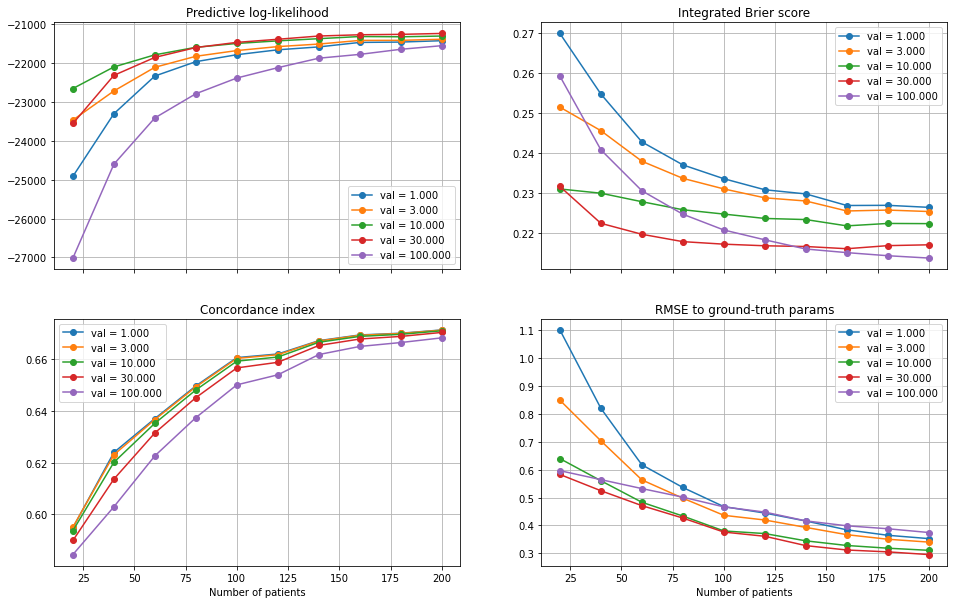

In [10]:
fig, axs = plot_res(res_lm, l2s);

In [11]:
%%time
def temporal_difference(model, l2, seqs, ts, cs):
    model.params = np.zeros_like(model.params)
    seqs_, ts_, cs_ = unroll(seqs, ts, cs)
    model.fit(seqs_, ts_, cs_, lambda_=0.0, n_iters=30, l2=l2)

l2s = np.array([0.0, 0.1, 1.0, 10.0, 30.0])
res_td = experiment(temporal_difference, l2s)

..........
..........
..........
..........
..........
CPU times: user 2min 57s, sys: 6.83 s, total: 3min 4s
Wall time: 2min 3s


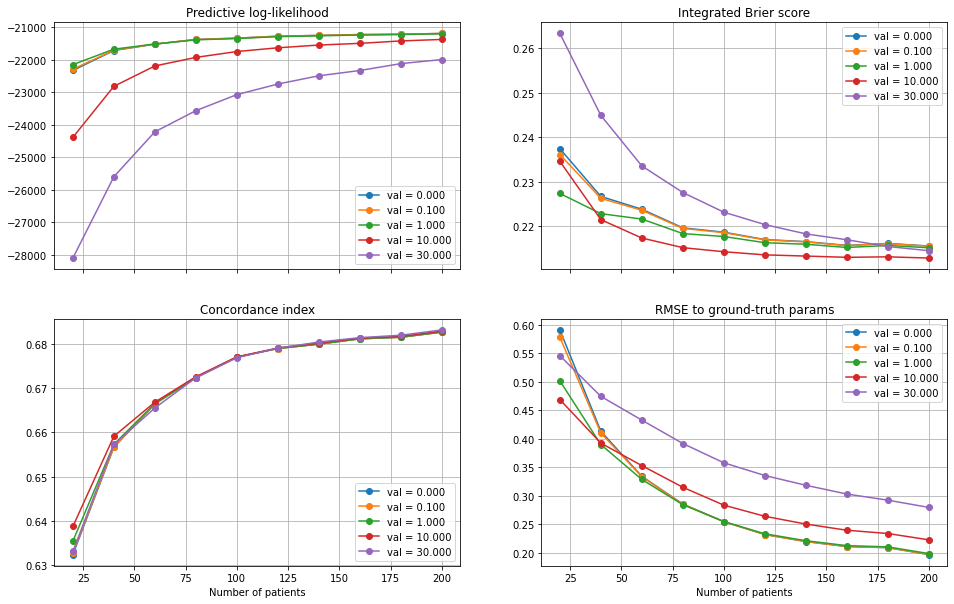

In [12]:
fig, axs = plot_res(res_td, l2s);

## Final plots

For each metric and each method, we select the $\ell_2$ regularization parameter that gives the best result in the plots above.

### Metric 1: predictive log-likelihood

In [13]:
%%time
model = CoxPH(horizon=horizon, n_feats=d)

sizes = 20 * np.arange(1, 11)

res1_is = np.zeros((n_folds, len(sizes)))
res1_lm = np.zeros((n_folds, len(sizes)))
res1_td = np.zeros((n_folds, len(sizes)))

for fold in range(n_folds):
    seqs_t, ts_t, cs_t = data[fold]
    for i, size in enumerate(sizes):
        print(".", end="")
        seqs_, ts_, cs_ = unroll(seqs_t[:size], ts_t[:size], cs_t[:size])
        # Initial state.
        model.params = np.zeros_like(model.params)
        model.fit(seqs_t[:size], ts_t[:size], cs_t[:size], lambda_=1.0, l2=10.0)
        res1_is[fold, i] = model.loglike(seqs_v[:, 0], ts_v, cs_v)
        # Landmarking.
        model.params = np.zeros_like(model.params)
        model.fit(seqs_, ts_, cs_, lambda_=1.0, l2=10.0)
        res1_lm[fold, i] = model.loglike(seqs_v[:, 0], ts_v, cs_v)
        # Temporal difference.
        model.params = np.zeros_like(model.params)
        model.fit(seqs_, ts_, cs_, lambda_=0.0, n_iters=100, l2=1.0)
        res1_td[fold, i] = model.loglike(seqs_v[:, 0], ts_v, cs_v)
    print()

..........
..........
..........
..........
..........
CPU times: user 2min 25s, sys: 4.07 s, total: 2min 30s
Wall time: 1min 56s


Text(0.5, 0, 'Number of sequences')

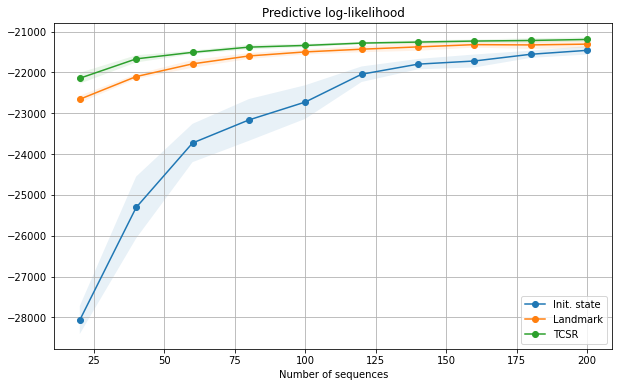

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))

for res, label in ((res1_is, "Init. state"), (res1_lm, "Landmark"), (res1_td, "TCSR")):
    mean = res.mean(axis=0)
    std = res.std(axis=0) / np.sqrt(n_folds)
    ax.plot(sizes, mean, marker="o", label=label)
    ax.fill_between(sizes, mean - std, mean + std, alpha=0.1)

ax.legend(loc="lower right")
ax.grid()
ax.set_title("Predictive log-likelihood")
ax.set_xlabel("Number of sequences")

### Metric 2: integrated Brier score

In [15]:
%%time
model = CoxPH(horizon=horizon, n_feats=d)

sizes = 20 * np.arange(1, 11)

res2_is = np.zeros((n_folds, len(sizes)))
res2_lm = np.zeros((n_folds, len(sizes)))
res2_td = np.zeros((n_folds, len(sizes)))

for fold in range(n_folds):
    seqs_t, ts_t, cs_t = data[fold]
    for i, size in enumerate(sizes):
        print(".", end="")
        seqs_, ts_, cs_ = unroll(seqs_t[:size], ts_t[:size], cs_t[:size])
        # Initial state.
        model.params = np.zeros_like(model.params)
        model.fit(seqs_t[:size], ts_t[:size], cs_t[:size], lambda_=1.0, l2=10.0)
        res2_is[fold, i] = model.integrated_brier_score(seqs_v[:, 0], ts_v, cs_v)
        # Landmarking.
        model.params = np.zeros_like(model.params)
        model.fit(seqs_, ts_, cs_, lambda_=1.0, l2=30.0)
        res2_lm[fold, i] = model.integrated_brier_score(seqs_v[:, 0], ts_v, cs_v)
        # Temporal difference.
        model.params = np.zeros_like(model.params)
        model.fit(seqs_, ts_, cs_, lambda_=0.0, n_iters=100, l2=10.0)
        res2_td[fold, i] = model.integrated_brier_score(seqs_v[:, 0], ts_v, cs_v)
    print()

..........
..........
..........
..........
..........
CPU times: user 2min 12s, sys: 3.46 s, total: 2min 16s
Wall time: 1min 50s


Text(0.5, 0, 'Number of sequences')

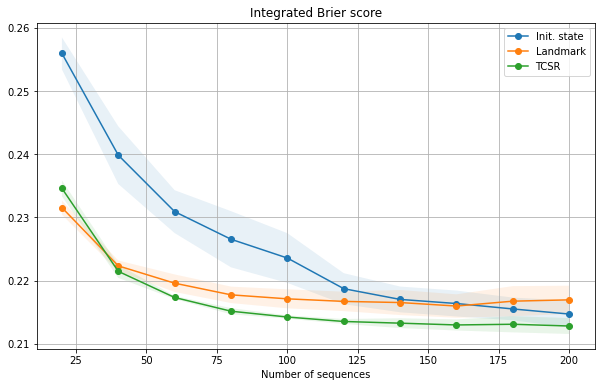

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))

for res, label in ((res2_is, "Init. state"), (res2_lm, "Landmark"), (res2_td, "TCSR")):
    mean = res.mean(axis=0)
    std = res.std(axis=0) / np.sqrt(n_folds)
    ax.plot(sizes, mean, marker="o", label=label)
    ax.fill_between(sizes, mean - std, mean + std, alpha=0.1)

ax.legend()
ax.grid()
ax.set_title("Integrated Brier score")
ax.set_xlabel("Number of sequences")

### Metric 3: concordance index

In [17]:
%%time
model = CoxPH(horizon=horizon, n_feats=d)

sizes = 20 * np.arange(1, 11)

res3_is = np.zeros((n_folds, len(sizes)))
res3_lm = np.zeros((n_folds, len(sizes)))
res3_td = np.zeros((n_folds, len(sizes)))

for fold in range(n_folds):
    seqs_t, ts_t, cs_t = data[fold]
    for i, size in enumerate(sizes):
        print(".", end="")
        seqs_, ts_, cs_ = unroll(seqs_t[:size], ts_t[:size], cs_t[:size])
        # Initial state.
        model.params = np.zeros_like(model.params)
        model.fit(seqs_t[:size], ts_t[:size], cs_t[:size], lambda_=1.0, l2=10.0)
        res3_is[fold, i] = concordance_index(model.score(seqs_v[:, 0]), ts_v, cs_v)
        # Landmarking.
        model.params = np.zeros_like(model.params)
        model.fit(seqs_, ts_, cs_, lambda_=1.0, l2=3.0)
        res3_lm[fold, i] = concordance_index(model.score(seqs_v[:, 0]), ts_v, cs_v)
        # Temporal difference.
        model.params = np.zeros_like(model.params)
        model.fit(seqs_, ts_, cs_, lambda_=0.0, n_iters=100, l2=10.0)
        res3_td[fold, i] = concordance_index(model.score(seqs_v[:, 0]), ts_v, cs_v)
    print()

..........
..........
..........
..........
..........
CPU times: user 2min 19s, sys: 3 s, total: 2min 22s
Wall time: 1min 57s


Text(0.5, 0, 'Number of sequences')

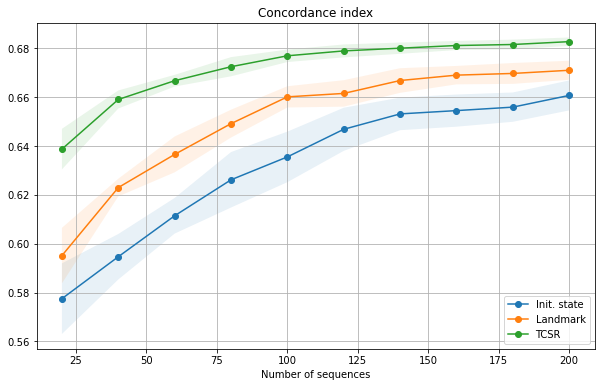

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))

for res, label in ((res3_is, "Init. state"), (res3_lm, "Landmark"), (res3_td, "TCSR")):
    mean = res.mean(axis=0)
    std = res.std(axis=0) / np.sqrt(n_folds)
    ax.plot(sizes, mean, marker="o", label=label)
    ax.fill_between(sizes, mean - std, mean + std, alpha=0.1)

ax.legend(loc="lower right")
ax.grid()
ax.set_title("Concordance index")
ax.set_xlabel("Number of sequences")

### Metric 4: RMSE

In [19]:
%%time
model = CoxPH(horizon=horizon, n_feats=d)

sizes = 20 * np.arange(1, 11)

res4_is = np.zeros((n_folds, len(sizes)))
res4_lm = np.zeros((n_folds, len(sizes)))
res4_td = np.zeros((n_folds, len(sizes)))

for fold in range(n_folds):
    seqs_t, ts_t, cs_t = data[fold]
    for i, size in enumerate(sizes):
        print(".", end="")
        seqs_, ts_, cs_ = unroll(seqs_t[:size], ts_t[:size], cs_t[:size])
        # Initial state.
        model.params = np.zeros_like(model.params)
        model.fit(seqs_t[:size], ts_t[:size], cs_t[:size], lambda_=1.0, l2=30.0)
        res4_is[fold, i] = np.linalg.norm(model.params[:n_dims] - params_gt)
        # Landmarking.
        model.params = np.zeros_like(model.params)
        model.fit(seqs_, ts_, cs_, lambda_=1.0, l2=30.0)
        res4_lm[fold, i] = np.linalg.norm(model.params[:n_dims] - params_gt)
        # Temporal difference.
        model.params = np.zeros_like(model.params)
        model.fit(seqs_, ts_, cs_, lambda_=0.0, n_iters=100, l2=10.0)
        res4_td[fold, i] = np.linalg.norm(model.params[:n_dims] - params_gt)
    print()

..........
..........
..........
..........
..........
CPU times: user 2min 5s, sys: 3 s, total: 2min 8s
Wall time: 1min 43s


Text(0.5, 0, 'Number of sequences')

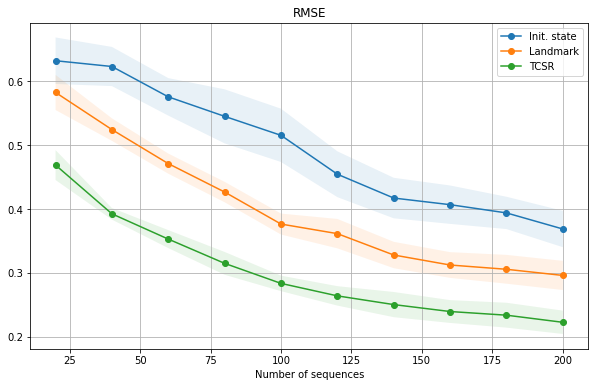

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))

for res, label in ((res4_is, "Init. state"), (res4_lm, "Landmark"), (res4_td, "TCSR")):
    mean = res.mean(axis=0)
    std = res.std(axis=0) / np.sqrt(n_folds)
    ax.plot(sizes, mean, marker="o", label=label)
    ax.fill_between(sizes, mean - std, mean + std, alpha=0.1)

ax.legend()
ax.grid()
ax.set_title("RMSE")
ax.set_xlabel("Number of sequences")

## Save results for further plotting

In [21]:
with open("../data/fig-rweval.pkl", "wb") as f:
    pickle.dump({
        "xs": sizes,
        "loglike": (res1_is, res1_lm, res1_td),
        "brier": (res2_is, res2_lm, res2_td),
        "concord": (res3_is, res3_lm, res3_td),
        "rmse": (res4_is, res4_lm, res4_td),
    }, f)